In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import os
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
from PIL import Image, ImageChops, ImageFilter, ImageOps
from IPython.display import display

# --- 1. פונקציית עזר לשמירה על פרופורציות (Padding) ---
def resize_with_padding(img, size=(512, 512)):
    # פונקציה שמוסיפה שוליים לבנים במקום למתוח את התמונה
    img.thumbnail(size, Image.LANCZOS)
    new_img = Image.new("RGB", size, (255, 255, 255))
    new_img.paste(img, ((size[0] - img.size[0]) // 2, (size[1] - img.size[1]) // 2))
    return new_img

# --- 2. טעינת המודל ---
if 'pipe' not in locals():
    pipe = AutoPipelineForInpainting.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        torch_dtype=torch.float16,
        variant="fp16"
    ).to("cuda")

# --- 3. הגדרות נתיבים ---
brand = "Nike"
img_num = "3"

original_path = f"/content/drive/MyDrive/originals VS fake/original/{brand}/{img_num}.png"
blank_path = f"/content/drive/MyDrive/originals VS fake/blank/{brand}/{img_num}_cleanup.png"

# יצירת התיקיות
output_base = f"/content/drive/MyDrive/originals VS fake/output_results/{brand}"
fake_dir = os.path.join(output_base, "fake")
mask_dir = os.path.join(output_base, "mask")
os.makedirs(fake_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

if os.path.exists(original_path) and os.path.exists(blank_path):
    # --- 4. טעינה חכמה ללא כיווץ ---
    raw_orig = Image.open(original_path).convert("RGB")
    raw_blank = Image.open(blank_path).convert("RGB")

    # שינוי גודל תוך שמירה על הפרופורציה המקורית (הוספת שוליים לבנים)
    original = resize_with_padding(raw_orig)
    blank = resize_with_padding(raw_blank)

    # --- 5. יצירת מסכה וזיוף ---
    diff = ImageChops.difference(original, blank)
    mask = diff.convert("L").point(lambda x: 255 if x > 15 else 0)
    mask = mask.filter(ImageFilter.MaxFilter(9)).filter(ImageFilter.GaussianBlur(radius=5))

    print(f"Generating {brand} {img_num} - Fixed Proportions")

    with torch.autocast("cuda"):
        image_fake = pipe(
            prompt=f"a distorted bootleg {brand} logo, messy embroidery, fake brand mark, colorful",
            negative_prompt="clean shoe, no logo, blurry, watermark",
            image=blank,
            mask_image=mask,
            num_inference_steps=40,
            strength=0.99,
            guidance_scale=13.0
        ).images[0]

    # --- 6. שמירה ותצוגה ---
    image_fake.save(os.path.join(fake_dir, f"{img_num}_fake.png"))
    mask.save(os.path.join(mask_dir, f"{img_num}_mask.png"))

    # תצוגה של המקור מול הזיוף
    comparison = Image.new('RGB', (1024, 512))
    comparison.paste(original, (0, 0))
    comparison.paste(image_fake, (512, 0))
    display(comparison)

KeyboardInterrupt: 

🔍 מנתח 4 מותגים (לא כולל את: PUMA, HOKA, CONVERSE)


/tmp/ipython-input-2677043408.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Brand', order=brand_order, palette='magma')


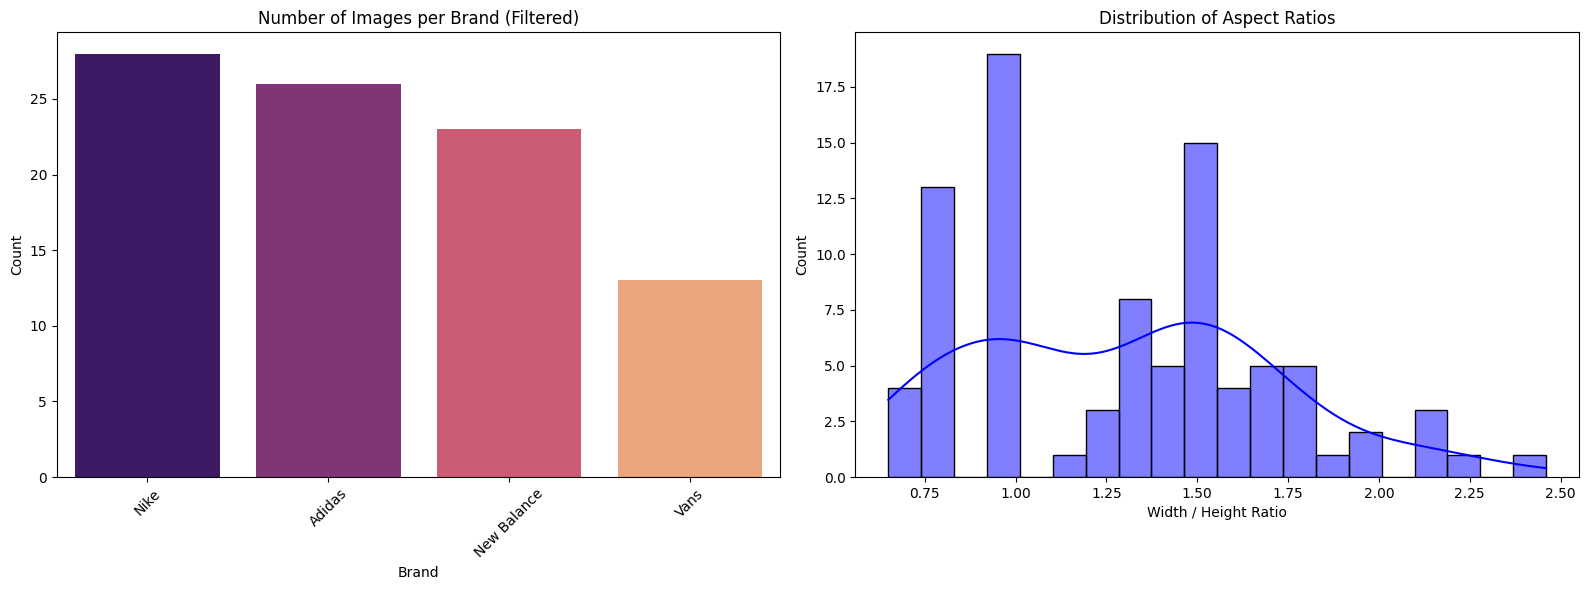


--- Summary Report ---
         Brand  Count
0       Adidas     26
1  New Balance     23
2         Nike     28
3         Vans     13


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# --- הגדרות נתיבים ---
base_path = "/content/drive/MyDrive/originals VS fake"
orig_base = os.path.join(base_path, "original")
blank_base = os.path.join(base_path, "blank")

# רשימת המותגים שאת רוצה להחריג (לא להציג)
exclude_brands = ["PUMA", "HOKA", "CONVERSE"]

def perform_filtered_eda():
    data_summary = []

    # 1. סריקת המותגים בתיקיית original
    all_brands = [d for d in os.listdir(orig_base) if os.path.isdir(os.path.join(orig_base, d))]

    # סינון המותגים הלא רצויים
    brands = [b for b in all_brands if b.upper() not in [x.upper() for x in exclude_brands]]

    print(f"🔍 מנתח {len(brands)} מותגים (לא כולל את: {', '.join(exclude_brands)})")

    for brand in brands:
        brand_path = os.path.join(orig_base, brand)
        images = [f for f in os.listdir(brand_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

        for img_name in images:
            img_id = os.path.splitext(img_name)[0]

            # בדיקת קיום קובץ cleanup (תומך בפורמטים שונים)
            cleanup_path = os.path.join(blank_base, f"{img_id}_cleanup.png")
            cleanup_exists = os.path.exists(cleanup_path) or os.path.exists(os.path.join(blank_base, f"{img_id}.png"))

            try:
                with Image.open(os.path.join(brand_path, img_name)) as img:
                    width, height = img.size

                data_summary.append({
                    'Brand': brand,
                    'Image_ID': img_id,
                    'Width': width,
                    'Height': height,
                    'Has_Cleanup': cleanup_exists,
                    'Aspect_Ratio': round(width / height, 2)
                })
            except:
                continue

    if not data_summary:
        print("לא נמצאו נתונים להצגה.")
        return

    df = pd.DataFrame(data_summary)

    # --- ויזואליזציה ---
    plt.figure(figsize=(16, 6))

    # גרף 1: כמות תמונות לכל מותג (ללא המותגים שהוחרגו)
    plt.subplot(1, 2, 1)
    # שימוש ב-order כדי שהגרף יהיה מסודר לפי כמות
    brand_order = df['Brand'].value_counts().index
    sns.countplot(data=df, x='Brand', order=brand_order, palette='magma')
    plt.title("Number of Images per Brand (Filtered)")
    plt.xticks(rotation=45) # סיבוב שמות המותגים לנוחות קריאה
    plt.ylabel("Count")

    # גרף 2: התפלגות יחס גובה-רוחב (כדי לראות אם יש עיוותים)
    plt.subplot(1, 2, 2)
    sns.histplot(df['Aspect_Ratio'], bins=20, kde=True, color='blue')
    plt.title("Distribution of Aspect Ratios")
    plt.xlabel("Width / Height Ratio")

    plt.tight_layout()
    plt.show()

    # דו"ח סיכום קצר
    print("\n--- Summary Report ---")
    print(df.groupby('Brand').size().reset_index(name='Count'))

    return df

# הרצת ה-EDA המסונן
df_stats = perform_filtered_eda()

/tmp/ipython-input-787905080.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_fakes, x='Brand', y='Generated_Fakes', palette='viridis')


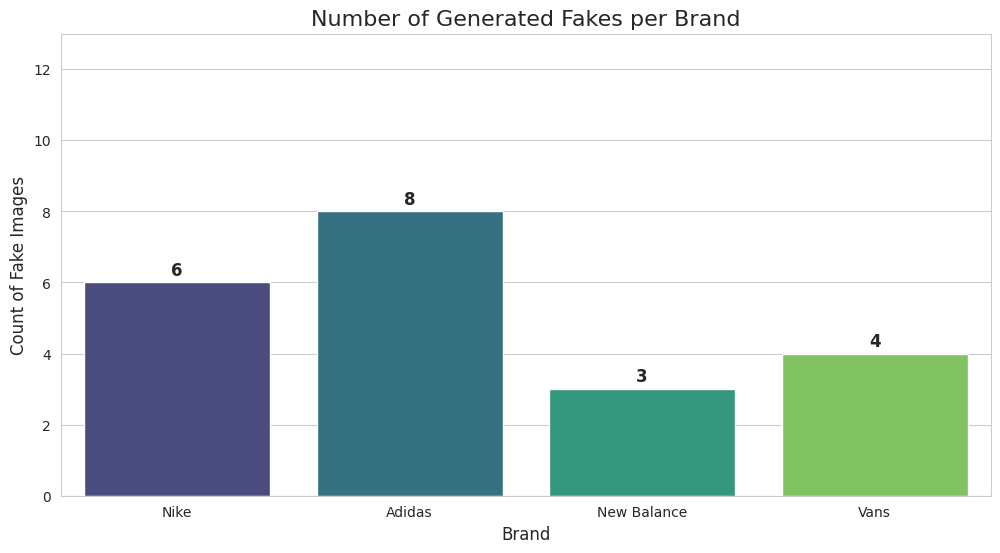

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- הגדרות נתיבים ---
output_base = "/content/drive/MyDrive/originals VS fake/output_results"
exclude_brands = ["PUMA", "HOKA", "CONVERSE"]

def plot_generated_fakes_eda():
    fakes_data = []

    if not os.path.exists(output_base):
        print("❌ תיקיית התוצאות לא נמצאה.")
        return

    # סריקת תיקיות המותגים בתוך output_results
    brands = [d for d in os.listdir(output_base) if os.path.isdir(os.path.join(output_base, d))]

    for brand in brands:
        # סינון מותגים שלא רוצים להציג
        if brand.upper() in [x.upper() for x in exclude_brands]:
            continue

        fake_folder = os.path.join(output_base, brand, "fake")

        if os.path.exists(fake_folder):
            # ספירת קבצים שמסתיימים ב-_fake.png או .png
            num_fakes = len([f for f in os.listdir(fake_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

            fakes_data.append({
                'Brand': brand,
                'Generated_Fakes': num_fakes
            })

    if not fakes_data:
        print("🔍 לא נמצאו זיופים בתיקיות ה-fake עדיין.")
        return

    df_fakes = pd.DataFrame(fakes_data)

    # --- יצירת הגרף ---
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # צבע ירוק כדי להבדיל מהגרף של המקורות
    ax = sns.barplot(data=df_fakes, x='Brand', y='Generated_Fakes', palette='viridis')

    # הוספת מספרים מעל העמודות
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points',
                   fontsize=12, fontweight='bold')

    plt.title("Number of Generated Fakes per Brand", fontsize=16)
    plt.xlabel("Brand", fontsize=12)
    plt.ylabel("Count of Fake Images", fontsize=12)
    plt.ylim(0, df_fakes['Generated_Fakes'].max() + 5) # הוספת מרווח למעלה למספרים

    plt.show()

# הרצת הגרף
plot_generated_fakes_eda()